In [1]:
# General Imports
import numpy as np
from math import pi
import datetime
import json
import copy
# Visualisation Imports
import matplotlib.pyplot as plt

# Pandas Imports
import pandas as pd

#Seaborn Imports
from seaborn import heatmap

# Qiskit Imports
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.kernels import QuantumKernel

# sklearn import
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef

# scipy import
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import wilcoxon
from scipy.stats import sem
# statsmodels import
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Receiver Operating Characteristic (ROC) with cross validation

inspired by:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [2]:
def mean_plus_bounds(metrics):
    mean_metric =  np.mean(metrics)
    sem_metric =  sem(metrics)
    l_bound = mean_metric - 1.96*sem_metric
    u_bound = mean_metric + 1.96*sem_metric
    return  str(round(mean_metric + 0.0005,5))[0:5].lstrip('0') \
            +' ['+ str(round(l_bound+0.0005,5))[0:5].lstrip('0') \
            +', '+ str(round(u_bound+0.0005,5))[0:5].lstrip('0') + ']'

In [3]:
def compute_metrics(test_y_list, y_pred_prob_list, toggle = True, individual = True,
                   title=f"Mean ROC curve with variability"):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    accs = []
    baccs = []
    precisions_1 = []
    precisions_0 = []
    recalls_1 = []
    recalls_0 = []
    f1_scores_1 = []
    f1_scores_0 = []
    
    for fold, test_y in enumerate(test_y_list):
        
        #if fold%5 == 0:
            #print("Model", model_name)

        predict_prob = np.array(y_pred_prob_list[fold])
        if toggle:
            predict_prob = 1 - predict_prob
            test_y = 1 - np.array(test_y)
        predicted = np.rint(np.array(predict_prob))
        
        fpr, tpr, _ = roc_curve(test_y, predict_prob)        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        
               
        # get metrics
        aucs.append(roc_auc_score(test_y, predict_prob))
        accs.append(accuracy_score(test_y, predicted))
        baccs.append(balanced_accuracy_score(test_y, predicted))
        
        recalls_1.append(recall_score(test_y, predicted,
                                        pos_label = 1, average = "binary"))
        recalls_0.append(recall_score(test_y, predicted,
                                        pos_label = 0, average = "binary"))
        
        precisions_1.append(precision_score(test_y, predicted,
                                        pos_label = 1, average = "binary"))
        precisions_0.append(precision_score(test_y, predicted,
                                        pos_label = 0, average = "binary"))
        
        f1_scores_1.append(f1_score(test_y, predicted,
                                        pos_label = 1, average = "binary"))
        f1_scores_0.append(f1_score(test_y, predicted,
                                        pos_label = 0, average = "binary"))
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    
    if individual:
        for fold in range(len(test_y_list)):
            ax.plot( mean_fpr, tprs[fold], color = "b", lw=1, alpha=0.5)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    sem_auc = sem(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label="ROC AUC score = " + mean_plus_bounds(aucs),
        lw=2,
        alpha=1.0,
    )

    sem_tpr = sem(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.96*sem_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.96*sem_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.4,
        label=r"95% CI of the Mean",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()
    
    print("ROC AUC score = " + mean_plus_bounds(aucs))
    
    print("Accuracy = " + mean_plus_bounds(accs))
          
    print("Balanced accuracy = " + mean_plus_bounds(baccs)) 
        
    print("Negative predictive value (precision 0) =" + mean_plus_bounds(precisions_0)) 
          
    print("Positive predictive value (precision 1)  =" + mean_plus_bounds(precisions_1)) 
    
    print("True negative rate (specificity, recall 0) = " + mean_plus_bounds(recalls_0)) 
    
    print("True positive rate (sensitivity, recall 1) = " + mean_plus_bounds(recalls_1)) 
       
    print("F1-score 0 =" + mean_plus_bounds(f1_scores_0))
         
    print("F1-score 1 =" + mean_plus_bounds(f1_scores_1)) 
    
   
    return aucs, accs, baccs, precisions_1, precisions_0, recalls_1, recalls_0, f1_scores_1,f1_scores_0, tprs

In [4]:
def plot_ROCs(plot_dic):
    
    fig, ax = plt.subplots(figsize=(6, 6))    
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (model_name, result_list) in enumerate(plot_dic.items()):
        tprs = result_list[1]
        mean_tpr = np.mean(tprs, axis=0)
        aucs = result_list[0][0]
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        sem_auc = sem(aucs)
        ax.plot(
            mean_fpr,
            mean_tpr,
            #color=plt.cm.RdYlBu(i),
            label= model_name + r": AUC = " + mean_plus_bounds(aucs),
            lw=2,
            alpha=0.8,
        )

        sem_tpr = sem(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96*sem_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96*sem_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            #color=plt.cm.RdYlBu(i),
            alpha=0.1,
            label=r"95% CI of the Mean",
        )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curves with variability",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

In [5]:
metric_list = ("AUC score", "Accuracy", "Balanced Accuracy", "Positive predictive value (precision 1)",
               "Negative predictive value (precision 0)",
               "True positive rate (sensitivity, recall 1)", "True negative rate (specificity, recall 0)",
               "f1_score", "f1_score, positive label = 0")

# AlexNet, Freezer, 2+18 Epochs, 10-fold

In [6]:
model_name = 'alexnet_model_f18_10'
#reading
with open(f"{model_name}_y_pred_prob_list_af18_10.txt", 'r') as f:
    y_pred_prob_list_af18_10 = json.loads(f.read()) 
with open(f"{model_name}_test_y_list_af18_10.txt", 'r') as f:
    test_y_list_af18_10 = json.loads(f.read()) 

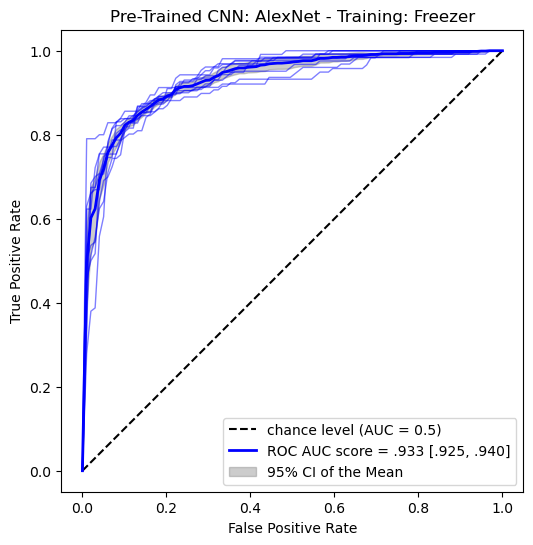

ROC AUC score = .933 [.925, .940]
Accuracy = .858 [.852, .863]
Balanced accuracy = .858 [.853, .864]
Negative predictive value (precision 0) =.858 [.843, .873]
Positive predictive value (precision 1)  =.858 [.835, .880]
True negative rate (specificity, recall 0) = .860 [.838, .881]
True positive rate (sensitivity, recall 1) = .857 [.844, .870]
F1-score 0 =.858 [.851, .865]
F1-score 1 =.856 [.850, .863]


In [7]:
F_Axnet18_10_C = compute_metrics(test_y_list_af18_10, y_pred_prob_list_af18_10, 
                                 title = "Pre-Trained CNN: AlexNet - Training: Freezer") 

In [8]:
#writing
with open('F-Axnet18-10-C-metrics.txt', 'w') as f:
    f.write(json.dumps(F_Axnet18_10_C[:-1]))
with open('F-Axnet18-10-C-tprs', 'wb') as f:
    np.save(f, F_Axnet18_10_C[-1])  

In [9]:
#reading
with open('F-Axnet18-10-C-metrics.txt', 'r') as f:
    F_Axnet18_10_C_metrics = json.loads(f.read()) 
with open('F-Axnet18-10-C-tprs', 'rb') as f:
    F_Axnet18_10_C_tprs = np.load(f)

# DenseNet 121, Freezer, 2+18 epochs, 10-fold

In [10]:
model_name = 'densenet121_model_fc10_18'
#reading
with open(f"densenet121_model_fc10_18_y_pred_prob_list_dcf10_18.txt", 'r') as f:
    y_pred_prob_list_fc10_18= json.loads(f.read()) 
with open(f"densenet121_model_fc10_18_test_y_list_dcf10_18.txt", 'r') as f:
    test_y_list_fc10_18 = json.loads(f.read()) 

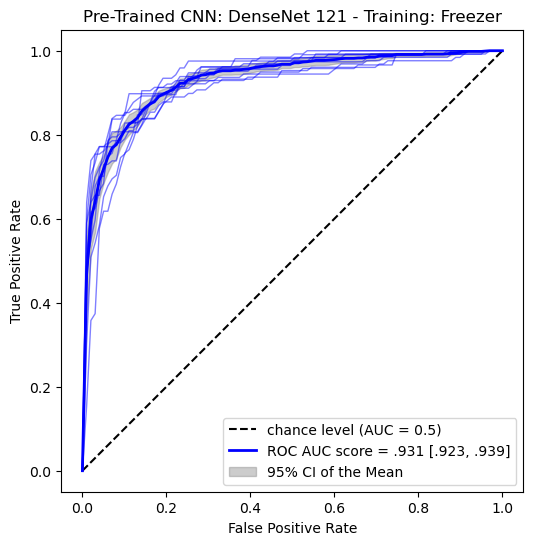

ROC AUC score = .931 [.923, .939]
Accuracy = .863 [.853, .873]
Balanced accuracy = .862 [.852, .873]
Negative predictive value (precision 0) =.845 [.831, .858]
Positive predictive value (precision 1)  =.884 [.870, .897]
True negative rate (specificity, recall 0) = .892 [.883, .902]
True positive rate (sensitivity, recall 1) = .832 [.812, .853]
F1-score 0 =.868 [.860, .876]
F1-score 1 =.857 [.842, .872]


In [11]:
F_Dnet18_10_C = compute_metrics(test_y_list_fc10_18, y_pred_prob_list_fc10_18, title = "Pre-Trained CNN: DenseNet 121 - Training: Freezer")           

In [12]:
#writing
with open('F-Dnet18-10-C-metrics.txt', 'w') as f:
    f.write(json.dumps(F_Dnet18_10_C[:-1]))
with open('F-Dnet18-10-C-tprs', 'wb') as f:
    np.save(f, F_Dnet18_10_C[-1])  

In [18]:
#reading
with open('F-Dnet18-10-C-metrics.txt', 'r') as f:
    F_Dnet18_10_C_metrics = json.loads(f.read()) 
with open('F-Dnet18-10-C-tprs', 'rb') as f:
    F_Dnet18_10_C_tprs = np.load(f)

# P 8q DenseNet 121, Freezer, 2+18 epochs, 10-fold

In [13]:
model_name = 'densenet121_model_p8q10_18'
#reading
with open("f_PL_qnn_model_8q_y_pred_prob_list.txt", 'r') as f:
    y_pred_prob_list_p8q10_18= json.loads(f.read()) 
with open("f_PL_qnn_model_8q_test_y_list.txt", 'r') as f:
    test_y_list_p8q10_18 = json.loads(f.read()) 

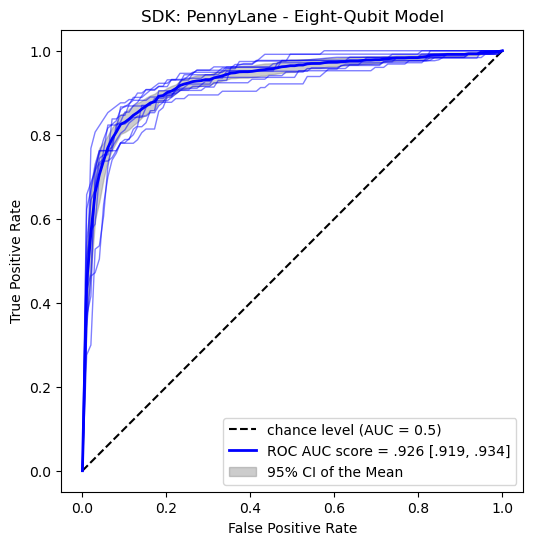

ROC AUC score = .926 [.919, .934]
Accuracy = .862 [.852, .873]
Balanced accuracy = .862 [.851, .873]
Negative predictive value (precision 0) =.844 [.827, .861]
Positive predictive value (precision 1)  =.887 [.860, .913]
True negative rate (specificity, recall 0) = .893 [.866, .920]
True positive rate (sensitivity, recall 1) = .830 [.803, .858]
F1-score 0 =.867 [.857, .877]
F1-score 1 =.856 [.842, .871]


In [14]:
F_Dnet18_10_p8 = compute_metrics(test_y_list_p8q10_18, y_pred_prob_list_p8q10_18, title = "SDK: PennyLane - Eight-Qubit Model")             

In [15]:
#writing
with open('F-Dnet18-10-p8-metrics.txt', 'w') as f:
    f.write(json.dumps(F_Dnet18_10_p8[:-1]))
with open('F-Dnet18-10-p8-tprs', 'wb') as f:
    np.save(f, F_Dnet18_10_p8[-1])  

In [16]:
#reading
with open('F-Dnet18-10-p8-metrics.txt', 'r') as f:
    F_Dnet18_10_p8_metrics = json.loads(f.read()) 
with open('F-Dnet18-10-p8-tprs', 'rb') as f:
    F_Dnet18_10_p8_tprs = np.load(f)

## Some stats 

A paired t-test seems justified as the same random seed was used for all models.



### PAIRED T-TEST    AxelNet vs DenseNet 121, Freezer
Ten-fold cross validation\n   Freezer models trained with 2+18 epochs

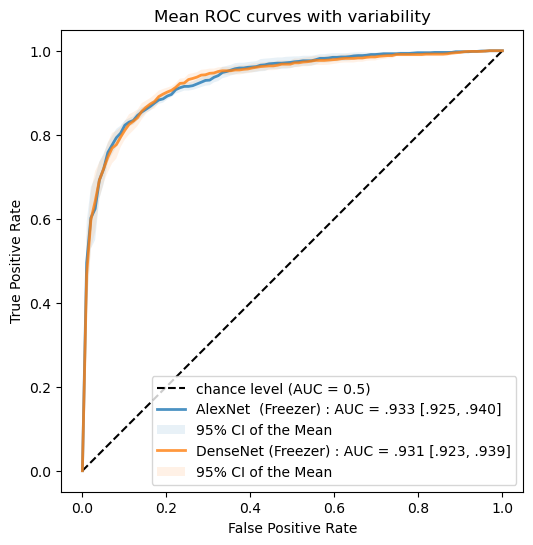

In [19]:
plot_ROCs({"AlexNet  (Freezer) ": [F_Axnet18_10_C_metrics, F_Axnet18_10_C_tprs],
           "DenseNet (Freezer) ": [F_Dnet18_10_C_metrics, F_Dnet18_10_C_tprs]})

In [20]:
print('PAIRED T-TEST    AxelNet 2+18 epochs vs DenseNet 121 2+18 epochs')
print('   Ten-fold cross validation\n   Freezer models\n')
for i, metric in enumerate (metric_list):
        print(metric+":")
        m1 = np.mean(F_Axnet18_10_C_metrics[i])
        s1 = np.std(F_Axnet18_10_C_metrics[i])
        m2 = np.mean(F_Dnet18_10_C_metrics[i])
        s2 = np.std(F_Dnet18_10_C_metrics[i]) 
        p = ttest_rel(F_Axnet18_10_C_metrics[i], F_Dnet18_10_C_metrics[i])[1]
        print("     %0.3f ± %0.3f vs %0.3f ± %0.3f  p = %0.5f" % (m1,s1,m2,s2,p))                                                                                         
        #print('\n')

PAIRED T-TEST    AxelNet 2+18 epochs vs DenseNet 121 2+18 epochs
   Ten-fold cross validation
   Freezer models

AUC score:
     0.933 ± 0.011 vs 0.931 ± 0.013  p = 0.57091
Accuracy:
     0.858 ± 0.008 vs 0.863 ± 0.016  p = 0.30709
Balanced Accuracy:
     0.858 ± 0.008 vs 0.862 ± 0.016  p = 0.47603
Positive predictive value (precision 1):
     0.858 ± 0.035 vs 0.884 ± 0.021  p = 0.02730
Negative predictive value (precision 0):
     0.858 ± 0.023 vs 0.845 ± 0.021  p = 0.19093
True positive rate (sensitivity, recall 1):
     0.857 ± 0.020 vs 0.832 ± 0.031  p = 0.09070
True negative rate (specificity, recall 0):
     0.860 ± 0.032 vs 0.892 ± 0.014  p = 0.02494
f1_score:
     0.856 ± 0.010 vs 0.857 ± 0.023  p = 0.95345
f1_score, positive label = 0:
     0.858 ± 0.011 vs 0.868 ± 0.012  p = 0.09538


### PAIRED T-TEST DenseNet 121,PennyLane 8-q vs classical
Ten-fold cross validation -  Freezer models trained with 2+18 epochs

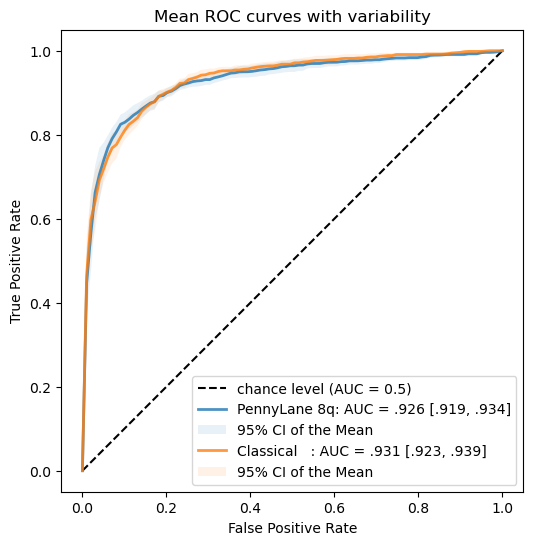

In [21]:
plot_ROCs({"PennyLane 8q": [F_Dnet18_10_p8_metrics, F_Dnet18_10_p8_tprs],
           "Classical   ": [F_Dnet18_10_C_metrics, F_Dnet18_10_C_tprs]})

In [23]:
print('PAIRED T-TEST    PennyLane 8q vs Classical, DenseNet 121')
print('   ten-folds cv   Freezer models\n')

for i, metric in enumerate (metric_list):
        print(metric+":")
        m1 = np.mean(F_Dnet18_10_p8_metrics[i])
        s1 = np.std(F_Dnet18_10_p8_metrics[i])
        m2 = np.mean(F_Dnet18_10_C_metrics[i])
        s2 = np.std(F_Dnet18_10_C_metrics[i]) 
        p = ttest_rel(F_Dnet18_10_p8_metrics[i], F_Dnet18_10_C_metrics[i])[1]
        print("     %0.3f ± %0.3f vs %0.3f ± %0.3f  p = %0.5f" % (m1,s1,m2,s2,p))                                                                                         
        #print('\n')

PAIRED T-TEST    PennyLane 8q vs Classical, DenseNet 121
   ten-folds cv   Freezer models

AUC score:
     0.926 ± 0.011 vs 0.931 ± 0.013  p = 0.21023
Accuracy:
     0.862 ± 0.015 vs 0.863 ± 0.016  p = 0.92548
Balanced Accuracy:
     0.862 ± 0.017 vs 0.862 ± 0.016  p = 0.93781
Positive predictive value (precision 1):
     0.887 ± 0.040 vs 0.884 ± 0.021  p = 0.77843
Negative predictive value (precision 0):
     0.844 ± 0.026 vs 0.845 ± 0.021  p = 0.97808
True positive rate (sensitivity, recall 1):
     0.830 ± 0.043 vs 0.832 ± 0.031  p = 0.92348
True negative rate (specificity, recall 0):
     0.893 ± 0.041 vs 0.892 ± 0.014  p = 0.94456
f1_score:
     0.856 ± 0.022 vs 0.857 ± 0.023  p = 0.91931
f1_score, positive label = 0:
     0.867 ± 0.015 vs 0.868 ± 0.012  p = 0.88534


## Confusion matrix

In [24]:
import seaborn as sns

In [41]:
def flatten(l):
    return [item for sublist in l for item in sublist]
def show_confusion(model_1, model_2, models, classes): 
    
    m1= np.rint(np.array(model_1))
    m2 = np.rint(np.array(model_2))
    cm = confusion_matrix(m1,m2)
    mcc = matthews_corrcoef(m1,m2)                
                          
    plt.figure(figsize=(8,6), dpi=100)
    sns.set(font_scale = 1.1)
    ax = sns.heatmap(cm, annot=True, fmt='d', )
    ax.set_xlabel(models[1], fontsize=14, labelpad=20)
    ax.set_ylabel(models[0], fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    ax.set_title("Confusion Matrix for the Cardiomegaly Detection Models"+\
                 "\n Matthew's Correlation Coefficient = %0.3f"%mcc, 
                 fontsize=14, pad=20)
    plt.show()

In [42]:
# reminder : the folds are identical across models
test_y_list_fc10_18 == test_y_list_af18_10 == test_y_list_p8q10_18

True

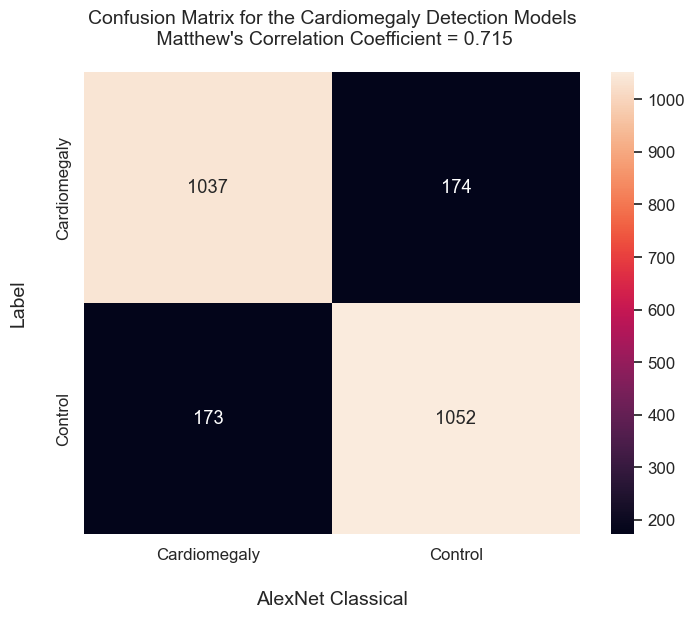

In [43]:
show_confusion(flatten(test_y_list_af18_10),
               flatten(y_pred_prob_list_af18_10),
               ["Label", "AlexNet Classical"],
               ['Cardiomegaly', 'Control'])

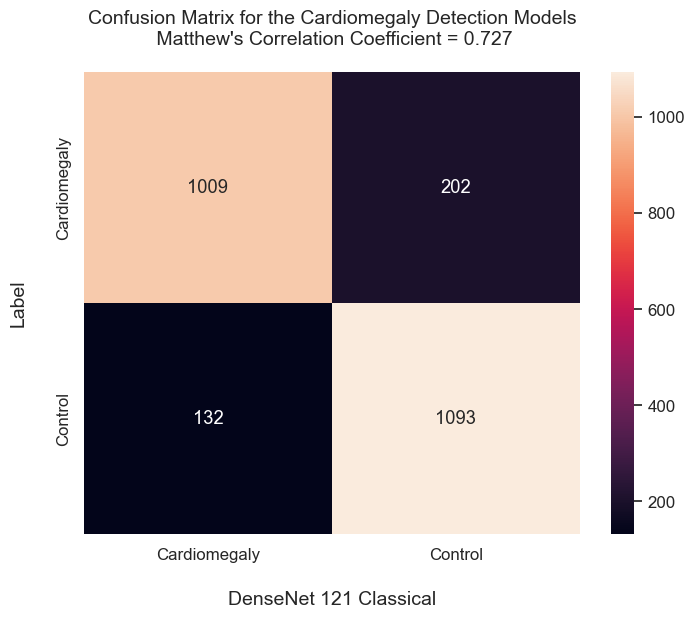

In [44]:
show_confusion(flatten(test_y_list_fc10_18),
               flatten(y_pred_prob_list_fc10_18),
               ["Label", "DenseNet 121 Classical"],
               ['Cardiomegaly', 'Control'])

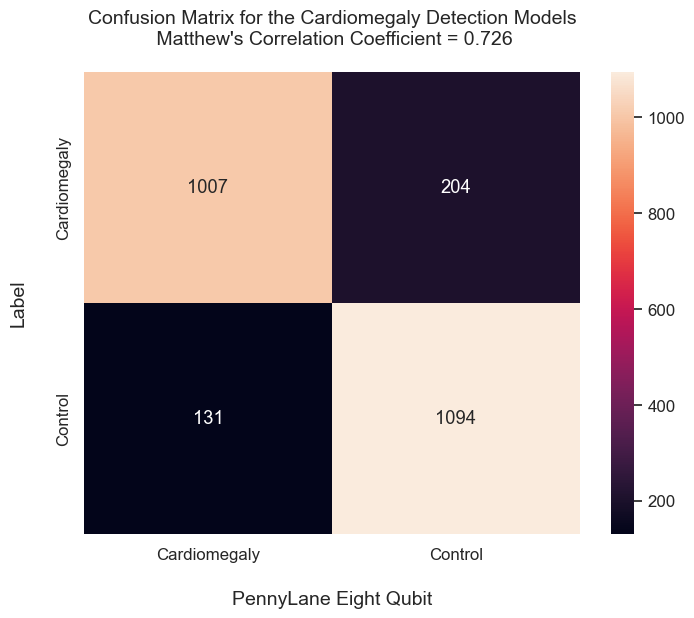

In [45]:
show_confusion(flatten(test_y_list_p8q10_18),
               flatten(y_pred_prob_list_p8q10_18),
               ["Label", "PennyLane Eight Qubit"],
               ['Cardiomegaly', 'Control'])

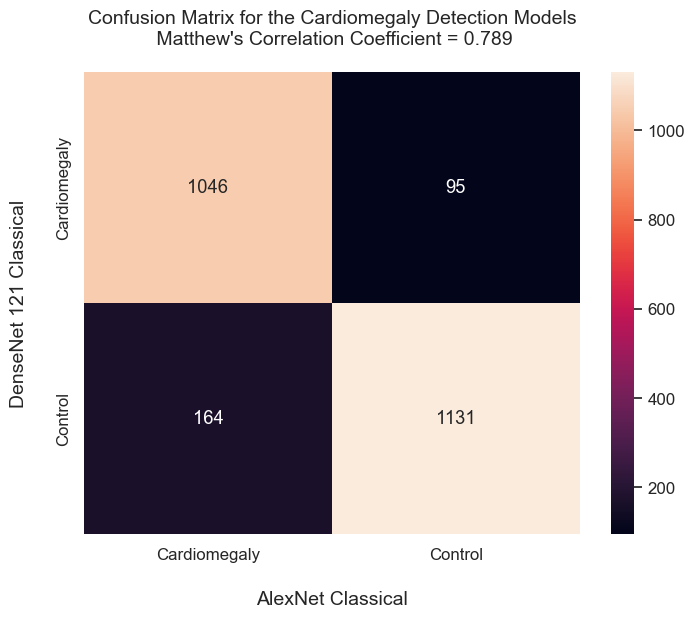

In [46]:
show_confusion(flatten(y_pred_prob_list_fc10_18),
               flatten(y_pred_prob_list_af18_10), #,              
               ["DenseNet 121 Classical", "AlexNet Classical"],
                ['Cardiomegaly', 'Control'])

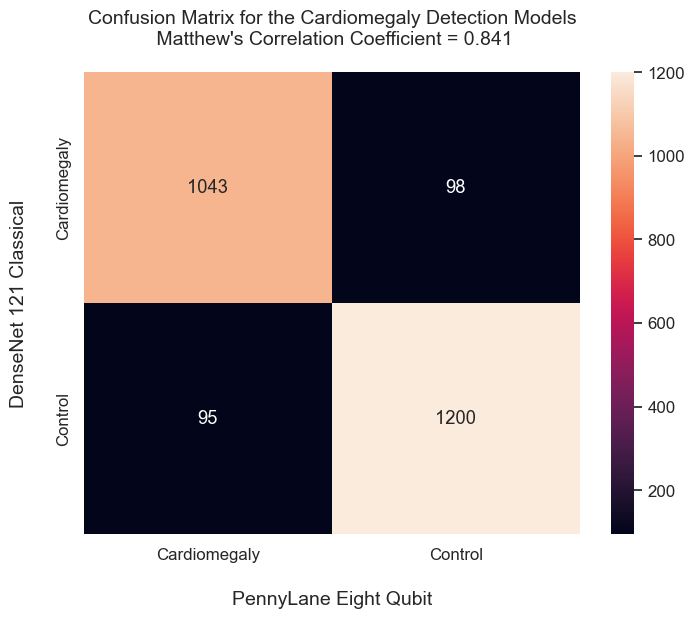

In [47]:
show_confusion(flatten(y_pred_prob_list_fc10_18),
               flatten(y_pred_prob_list_p8q10_18), #,              
               ["DenseNet 121 Classical", "PennyLane Eight Qubit"],
                ['Cardiomegaly', 'Control'])